# Image Classification using CNN

## Importing Libraries

In [2]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt
from imutils import paths
%matplotlib inline
from sklearn.model_selection import train_test_split

from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import cv2
import os

import warnings
from tqdm import tqdm_notebook as tqdm
import itertools

import tensorflow as tf
print(tf.__version__)
warnings.filterwarnings("ignore")
SEED = 42   # set random seed

2.15.0


In [5]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/DL Exam CNNs")

In [ ]:
!dir

dataset  test_examples	Untitled0.ipynb


## Defining the Model Architecture

In [ ]:
# create CNN model
class LeNet:
    @staticmethod
    def build(width, height, depth, classes):

        # initialize the model
        model = Sequential()
        inputShape = (height, width, depth) # (h, h, channel)

        # if we are using "channels first", update the input shape
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)

        # first set of CONV => RELU => POOL layers
        model.add(Conv2D(20, (5,5), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # second set of CONV => RELU => POOL layers
        model.add(Conv2D(50, (5,5), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # third set of CONV => RELU => POOL layers
        model.add(Conv2D(100, (5,5), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation("relu"))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model

## Loading the Data

In [ ]:
# Initializing the data and labels
print("[INFO] loading images...")
data = []
labels = []

# grab the image paths and randomly shuffle them
imagePaths = sorted(list(paths.list_images("dataset")))
random.seed(42)
random.shuffle(imagePaths)

# progress bar
with tqdm(total = len(imagePaths)) as pbar:

    # loop over the input images
    for idx, imagePath in enumerate(imagePaths):
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (28, 28))
        image = img_to_array(image)
        data.append(image)

        #extract the class labels from the image path and update the labels list

        label = imagePath.split(os.path.sep)[-2]
        if label == "Boots":
            label = 0
        elif label == "Sandals" :
            label = 1
        elif label == "Slippers":
            label = 2
        labels.append(label)

        pbar.update(1)




[INFO] loading images...


  0%|          | 0/778 [00:00<?, ?it/s]

In [ ]:
data[0].shape

(28, 28, 3)

In [ ]:
data = np.array(data, dtype = "float")/ 255.0
labels = np.array(labels)

In [ ]:
trainX, testX, trainY, testY = train_test_split(data, labels, test_size = 0.25, random_state=42)

In [ ]:
trainX.shape, testX.shape, trainY.shape, testY.shape

((583, 28, 28, 3), (195, 28, 28, 3), (583,), (195,))

In [ ]:
# this is necessary when the output layer is softmax
trainY =to_categorical(trainY, num_classes=3)
testY =to_categorical(testY, num_classes=3)

In [ ]:
trainY[0]

array([1., 0., 0.], dtype=float32)

In [ ]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=30,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         shear_range=0.2,
                         zoom_range=0.2,
                         horizontal_flip = True,
                         fill_mode = "nearest")

## Model Training

In [ ]:
EPOCHS = 150
INIT_LR = 0.001
BS = 32

# initialize the model
print("[INFO] compiling the model...")
model = LeNet.build(width=28, height=28, depth=3, classes=3)
opt = Adam(learning_rate = INIT_LR)

model.compile(loss="categorical_crossentropy", optimizer= opt, metrics=["accuracy"])
print("[INFO] model compiled...")

[INFO] compiling the model...
[INFO] model compiled...


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 20)        1520      
                                                                 
 activation (Activation)     (None, 28, 28, 20)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 20)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 50)        25050     
                                                                 
 activation_1 (Activation)   (None, 14, 14, 50)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 50)          0         
 g2D)                                                   

In [ ]:
# train the network
EPOCH = 150
print("[INFO] training network...")
H = model.fit(x = aug.flow(trainX, trainY, batch_size=BS),
              validation_data = (testX, testY),
              steps_per_epoch = len(trainX)//BS,
              epochs= EPOCH,
              verbose= 1)

# saving the model
print("[INFO] serializing netword")
model.save(f"cnn_model_{EPOCH}.h5")

[INFO] training network...
Epoch 1/150
18/18 [==============================] - 7s 88ms/step - loss: 1.0307 - accuracy: 0.4483 - val_loss: 0.9373 - val_accuracy: 0.4359
Epoch 2/150
18/18 [==============================] - 0s 20ms/step - loss: 0.8078 - accuracy: 0.6261 - val_loss: 0.7678 - val_accuracy: 0.6000
Epoch 3/150
18/18 [==============================] - 0s 20ms/step - loss: 0.7071 - accuracy: 0.6715 - val_loss: 0.5025 - val_accuracy: 0.7795
Epoch 4/150
18/18 [==============================] - 0s 20ms/step - loss: 0.6635 - accuracy: 0.6788 - val_loss: 0.5156 - val_accuracy: 0.7846
Epoch 5/150
18/18 [==============================] - 0s 20ms/step - loss: 0.5889 - accuracy: 0.7459 - val_loss: 0.3972 - val_accuracy: 0.8462
Epoch 6/150
18/18 [==============================] - 0s 21ms/step - loss: 0.5795 - accuracy: 0.7332 - val_loss: 0.4704 - val_accuracy: 0.8205
Epoch 7/150
18/18 [==============================] - 0s 20ms/step - loss: 0.5077 - accuracy: 0.7659 - val_loss: 0.4330 - 

## Model Evaluation

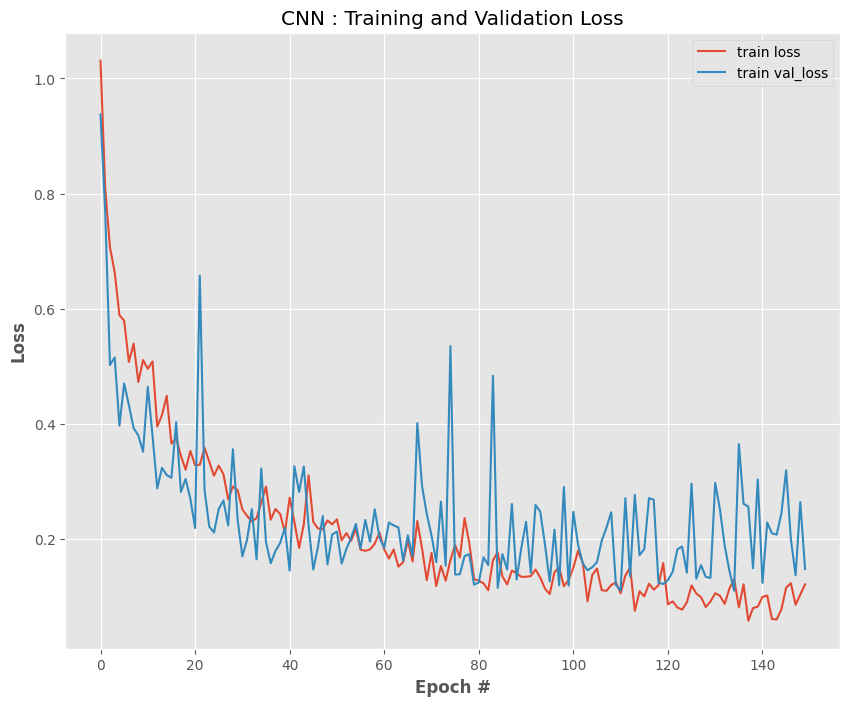

In [ ]:
# plot the training and validation loss
N = np.arange(0, 150)
plt.style.use("ggplot")
plt.figure(figsize=[10,8])
plt.plot(N, H.history["loss"], label = "train loss")
plt.plot(N, H.history["val_loss"], label = "train val_loss")
plt.title("CNN : Training and Validation Loss")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Loss", weight="bold")
plt.legend()
plt.show()

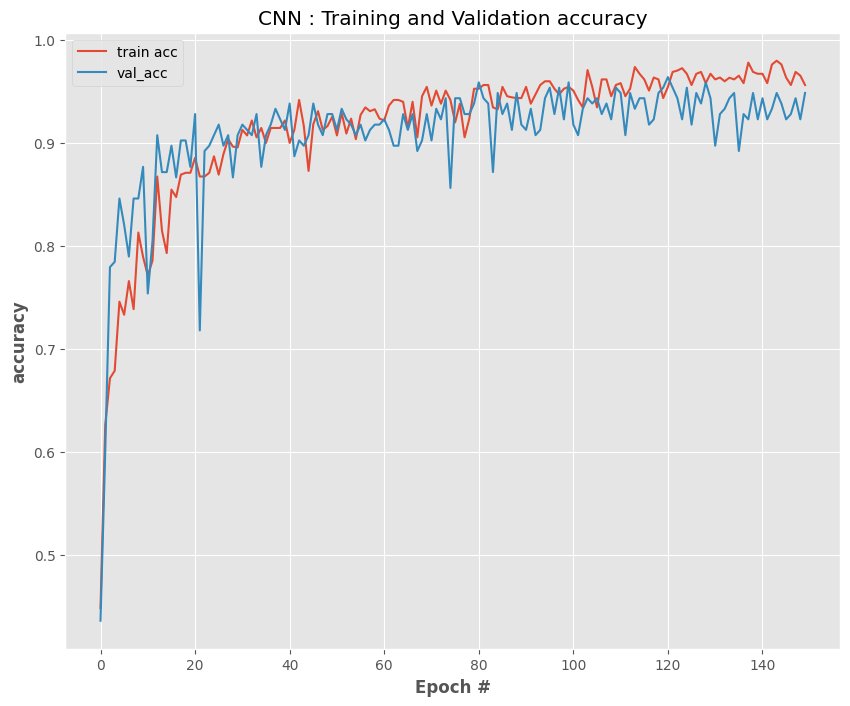

In [ ]:
# plot the training and validation loss
N = np.arange(0, 150)
plt.style.use("ggplot")
plt.figure(figsize=[10,8])
plt.plot(N, H.history["accuracy"], label = "train acc")
plt.plot(N, H.history["val_accuracy"], label = "val_acc")
plt.title("CNN : Training and Validation accuracy")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("accuracy", weight="bold")
plt.legend()
plt.show()

In [ ]:
# Classification Report for the model on the training data
predictions = model.predict(testX, batch_size=BS)
predicted_labels = np.argmax(predictions, axis=1)
print(classification_report(testY.argmax(axis=1), predicted_labels))

7/7 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.99      0.95      0.97        85
           1       0.89      0.99      0.94        74
           2       1.00      0.86      0.93        36

    accuracy                           0.95       195
   macro avg       0.96      0.93      0.94       195
weighted avg       0.95      0.95      0.95       195



### Evaluation Report  
**Model Accurcay = 95%**  
**Recall for Boots= 95%**  
**Recall for Sandals= 99%**  
**Recall for Slippers= 86%**


## Prediction for the test images

In [7]:
def display_img(img):
    fig = plt.figure(figsize=(12,10))
    # plt.grid(b=None)
    ax = fig.add_subplot(111)
    ax.imshow(img)

In [6]:
# # load the model

model = load_model("cnn_model_150.h5")

In [ ]:
# grab the image paths and randomly shuffle themt
testImagePaths = sorted(list(paths.list_images('test_examples')))

all_class = ["Boots", "Sandals", "Slippers"]


# progress bar
with tqdm(total=len(testImagePaths)) as pbar:

    for imagePath in testImagePaths:

        # load the image
        image = cv2.imread(imagePath)
        orig = image.copy()

        # pre-process the image for classification
        image = cv2.resize(image, (28, 28))
        image = image.astype("float") / 255.0
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)

        # classify the input image
        prd_conf= model.predict(image)[0] # [[0.1 , 0.8 , 0.1]]
        print(prd_conf)

        # build the label
        label = all_class[np.argmax(prd_conf)] #[b f s]-> f
        proba = prd_conf[np.argmax(prd_conf)] # [0.1 , 0.8 , 0.1]  -> 0.8

        label = "{}: {:.2f}%".format(label, proba * 100)

        # draw the label on the image
        output = imutils.resize(orig, width=400)
        cv2.putText(output, label, (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,
            0.7, (255, 0, 0), 2)

        # convert img to rgb format and display in notebook
        img = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
        display_img(img)

        pbar.update(1)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Assuming model is your trained CNN model
predictions = model.predict(testX, batch_size=BS)


7/7 [==============================] - 0s 8ms/step


In [ ]:
predicted_labels = np.argmax(predictions, axis=1)

## Deploying the Model on Gradio


In [ ]:
!pip install gradio

In [1]:
import gradio as gr

In [10]:
def predict_image(image):
    # load the image

    # pre-process the image for classification
    image = cv2.resize(image, (28, 28))
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)


    preds = model.predict(image)[0]
    result = dict()
    result["Boots"] = round(float(list(preds)[0]), 3)
    result["Sandals"] = round(float(list(preds)[1]), 3)
    result["Slippers"] = round(float(list(preds)[2]), 3)

    print(result)

    return result


im = gr.Image()
label = gr.Label(num_top_classes=3)

gr.Interface(fn=predict_image, inputs=im, outputs=label,  title="Image Classifier").launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://9e244d5da7b2d2bd1c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 20ms/step
{'Boots': 0.0, 'Sandals': 1.0, 'Slippers': 0.0}


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gradio/queueing.py", line 489, in call_prediction
    output = await route_utils.call_process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/route_utils.py", line 232, in call_process_api
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1561, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1179, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/usr/local/lib/python3.10/dist-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 877, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 807, in run
    re

1/1 [==============================] - 0s 27ms/step
{'Boots': 0.0, 'Sandals': 1.0, 'Slippers': 0.0}
1/1 [==============================] - 0s 18ms/step
{'Boots': 0.115, 'Sandals': 0.885, 'Slippers': 0.0}
1/1 [==============================] - 0s 18ms/step
{'Boots': 0.0, 'Sandals': 1.0, 'Slippers': 0.0}
1/1 [==============================] - 0s 18ms/step
{'Boots': 0.0, 'Sandals': 0.32, 'Slippers': 0.68}
1/1 [==============================] - 0s 18ms/step
{'Boots': 0.0, 'Sandals': 0.32, 'Slippers': 0.68}
1/1 [==============================] - 0s 18ms/step
{'Boots': 0.0, 'Sandals': 1.0, 'Slippers': 0.0}
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://9e244d5da7b2d2bd1c.gradio.live
